# Text - Summarization using abstractive summarization

###     we are going to use lstm encode-decode model for this. Abstractive methods select words based on semantic understanding, even those words did not appear in the source documents. It aims at producing important material in a new way. They interpret and examine the text using advanced natural language techniques in order to generate a new shorter text that conveys the most critical information from the original text.


### It can be correlated to the way human reads a text article or blog post and then summarizes in their own word.
Input document → understand context → semantics → create own summary.

## Problem statement :

 generate a summary for long food reviews.

## Dataset  : https://www.kaggle.com/snap/amazon-fine-food-reviews

In [1]:
import pandas as pd 
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
data = pd.read_csv("../Reviews.csv" , nrows=100000)

In [2]:
from attention import AttentionLayer

drops NA and duplicates

In [3]:
data.drop_duplicates(subset=['Text'] , inplace=True)
data.dropna(axis=0 , inplace = True)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [5]:
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
...,...,...,...,...,...,...,...,...,...,...
99995,99996,B000LQORDE,A2P7HIRYYWVOBD,Mason,2,5,5,1254096000,yummy!,I just love it and will buy another box when I'm done with last one!
99996,99997,B000LQORDE,A1K0ZH5MQFBA77,jennilight,2,5,4,1250985600,Tastes like More!,"My late father in law used to have a rating system for meals: if it was particularly tasty, he'd say ""This tastes like more!"" That's exactly how I felt the first time I tried a spicy picante ramyu..."
99997,99998,B000LQORDE,A29FRN2O7LWINL,T. Tsai,2,5,5,1237766400,Great ramen,"This is my favorite brand of Korean ramen. It is spicy so if you are not used to eating spicy food, make sure you don't use all of the spice pack. If you add an egg to the soup, it makes a great s..."
99998,99999,B000LQORDE,A9Q950IPXJR1D,"Lynda ""casual customer""",2,5,4,1237161600,Spicy!!,"I do like these noodles although, to say they are spicy is somewhat of an understatement. No one else in the family tolerates spicy very well so, seeing these, I was looking forward to an extra li..."


### we drop unwanted symbol , charectors from dataset that do not affect the objective of our problem.

In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because",                                   "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had                                   not", "hasn't": "has not", "haven't": "have not",
                        "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",                                     "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                         "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I                                    will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                         "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm":                                    "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords


8.Remove short words

In [7]:
from nltk.corpus import stopwords 


In [8]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
print(stopWords)


{"it's", 'how', 'he', 'those', 'your', "isn't", 'by', 're', 'herself', 'too', 'it', "you'll", 't', 'wouldn', 'them', 'than', "won't", 'weren', 'i', 'other', "mustn't", 'their', "should've", 'his', 'above', 'mustn', 'me', "you're", 'what', 'who', 'been', 's', 'mightn', 'o', 'into', 'shan', 'll', 'doesn', 'during', 'between', 'no', 'they', "she's", "that'll", 'few', 'have', "doesn't", 'shouldn', 'so', 'for', 'same', 'over', 'under', 'any', 'himself', 'from', 'yours', "weren't", 'isn', 'very', 'that', 'as', 'in', "hadn't", 'and', 'does', 'such', 'of', 'then', 'myself', 'this', 'yourselves', 'theirs', 'won', 'being', "wouldn't", 'below', 'hasn', 'which', 'wasn', 'we', 'nor', "don't", 'further', 'had', "shouldn't", 'through', 'y', 'having', "needn't", 'she', 'but', 'yourself', 'why', 'be', 'because', 'are', 'out', 'an', 'there', 'now', "shan't", "you'd", "mightn't", 'just', 'ours', 'if', 'ourselves', 'was', 'with', 'is', 'off', 'can', 'hers', 'were', 'did', 'down', 'about', 'needn', 'do', "

In [9]:
# for web-scrapping - removing HTML & XML
from bs4 import BeautifulSoup
import re


In [10]:
def text_cleaner(text , num):
    new_text = text.lower()
    new_text = BeautifulSoup(new_text, "lxml").text
    new_text = re.sub(r'\([^)]*\)', '', new_text)
    new_text = re.sub('"','', new_text)
    new_text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_text.split(" ")])    
    new_text = re.sub(r"'s","",new_text)
    new_text = re.sub("[^a-zA-Z]", " ", new_text) 
    new_text = re.sub('[m]{2,}', 'mm', new_text)
    if(num==0):
        tokens = [w for w in new_text.split() if not w in stopWords]
    else:
        tokens=new_text.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()




### call the function

In [11]:
cleaned_data = []
for t in data['Text']:
    cleaned_data.append(text_cleaner(t , 0))
    

### print text data

In [12]:
cleaned_data[ :5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

### now clean-up summary data

In [13]:

clean_summary = []
for t in data['Summary']:
    clean_summary.append(text_cleaner(t,1))
print(clean_summary[:5])

['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


### adding the clean text and clean summary in data table


In [14]:
data['clean_text'] = cleaned_data
data['clean_summary'] = clean_summary


In [15]:
import numpy as np
data.replace('', np.NaN, inplace=True)
data.dropna(axis=0,inplace=True)

data.count()

Id                        88351
ProductId                 88351
UserId                    88351
ProfileName               88351
HelpfulnessNumerator      88351
HelpfulnessDenominator    88351
Score                     88351
Time                      88351
Summary                   88351
Text                      88351
clean_text                88351
clean_summary             88351
dtype: int64

## Understanding the distribution of the sequences

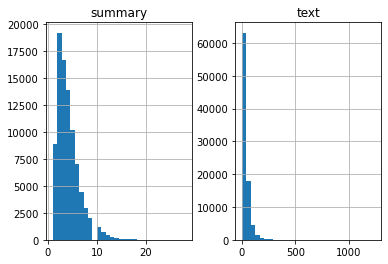

In [16]:
import matplotlib.pyplot as plt 
text_word_count =[]
summary_word_count = []

for i in data['clean_text']:
    text_word_count.append(len(i.split()))

for j in data['clean_summary']:
    summary_word_count.append(len(j.split()))


#representing data in graph
length_df = pd.DataFrame({'text' : text_word_count , 'summary' : summary_word_count})
length_df.hist(bins = 30)
plt.show()

### Let us understand the proportion of the length of summaries below 8

In [17]:
cnt = 0
for i in data['clean_summary']:
    if(len(i.split())  <= 8):
        cnt = cnt +1
print("The percentage of summaries with lenght less than 9 is ::" ,  cnt / len(data['clean_summary']))

The percentage of summaries with lenght less than 9 is :: 0.9425020656246109


### let's check for text data for 30 lenght 

In [18]:
te_cnt = 0
for i in data['clean_text']:
    if(len(i.split()) <= 40):
        te_cnt =te_cnt +1
print("the percentage of the data with length less or equal 30 is ::: " , te_cnt/len(data['clean_text']))

the percentage of the data with length less or equal 30 is :::  0.682493689941257


### we got that data with max lenght is about 50 % and with max length 40 is about 68 %. But here we have smaller machine for training so we choose max text length 30 data. because with lots of data the neural netwoo some time overfit so it will decrease accuracy


### so we decide that our system will give summary of atleast 9 words
### as well as we decide to take max length of text is 30

In [46]:
max_text_len = max_text_length= 30
max_summary_len = max_summary_length = 8

### so here we separate the data which text has max_lenght is 30 and summary have less then 9 lenght

## Data-set Creation

In [20]:
clean_text = np.array(data['clean_text'])
clean_summary = np.array(data['clean_summary']) 


short_text = []
short_summary = []

for i in range(len(clean_text)):
    if(len(clean_text[i].split()) <= max_text_length and len(clean_summary[i].split()) <= max_summary_length):
        short_text.append(clean_text[i])
        short_summary.append(clean_summary[i])

df = pd.DataFrame({'text' : short_text , 'summary' : short_summary})

In [21]:
df

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,great just as good as the expensive brands
...,...,...
47165,stuff awesome best flavor boil water drain water add spice packet add hot water,great stuff
47166,love noodle little spicy wife perfct,good stuff
47167,love buy another box done last one,yummy
47168,favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack,great ramen


### now we are inserting spacial tokan at the "starting"  and  "ending" of the summary.
### here we choose 'sostok' as start tokan & 'eostok' for end tokan.

In [22]:
df['summary'] = df['summary'].apply(lambda x :'sostok ' + x + ' eostok')
df

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,sostok great just as good as the expensive brands eostok
...,...,...
47165,stuff awesome best flavor boil water drain water add spice packet add hot water,sostok great stuff eostok
47166,love noodle little spicy wife perfct,sostok good stuff eostok
47167,love buy another box done last one,sostok yummy eostok
47168,favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack,sostok great ramen eostok


### deviding dataset into text and train set

In [23]:

from sklearn.model_selection import train_test_split

x_tr , x_val , y_tr , y_val = train_test_split( np.array(df['text']) , np.array(df['summary']) ,test_size = 0.1 , random_state = 0 , shuffle = True)
print(len(x_tr) , len(x_val) , len(y_tr) , len(y_val) )

42453 4717 42453 4717


## Convert words data in numarical form (preparing TOKENIZER)

## Text Summarizer

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



In [25]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))
print(len(x_tokenizer.word_counts.items()))


24934


## Rarewords and its Coverage
### Let us look at the proportion rare words and its total coverage in the entire text

### Here, I am defining the threshold to be 4 which means word whose count is below 4 is considered as a rare word

In [26]:
thresh=4

cnt=0 #gives me the no. of rare words whose count falls below threshold
tot_cnt=0 #gives the size of vocabulary (which means every unique words in the text)
freq=0
tot_freq=0
##tot_cnt --> cnt gives me the top most common words

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.14261650758002
Total Coverage of rare words: 2.956306874516583


### Let us define the tokenizer with top most common words for reviews.



In [27]:
#first we create tokeniser for reviews on the training dataset
x_tokenizer = Tokenizer(num_words=tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert the string sequence into integer sequence
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

#padding 0 upto the max_seq_len in both dataset , so that we can pass it through neural network
x_tr = pad_sequences(x_tr_seq , maxlen=max_text_length , padding='post')
x_val = pad_sequences(x_val_seq , maxlen=max_text_length , padding= 'post')

#size of dictonary 
x_voc = x_tokenizer.num_words + 1

x_voc

8443

##############################################################################################################################

## Summary Tokenizer

In [28]:
#prepare the tokenizer for reviews of the data

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

## Rarewords and its Coverage
### Let us look at the proportion rare words and its total coverage in the entire summary

### Here, I am defining the threshold to be 6 which means word whose count is below 6 is considered as a rare word

In [29]:
thresh = 4 

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0


for key , value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt +1 
    tot_freq = tot_freq + value
    if(value < thresh):
        cnt = cnt +1 
        freq = freq+value



#printing the percentage of the rare words & coverage of the rare words
print("% of the rare words in vocabulary is " , (cnt/tot_cnt)*100)
print("total coverage of the rare words is " , (freq /tot_freq)*100)

% of the rare words in vocabulary is  70.42904290429043
total coverage of the rare words is  3.998596510168554


### Let us define the tokenizer with top most common words for summary.



In [30]:
#preparing the tokenizer for reviews on training dataset
y_tokenizer = Tokenizer(num_words= tot_cnt - cnt)
y_tokenizer.fit_on_texts(y_tr)

#convert data & summary text string into numbers sequence
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

#padding 0 upto max length
y_tr = pad_sequences(y_tr_seq , maxlen=max_summary_length , padding = "post")
y_val = pad_sequences(y_val_seq , maxlen = max_summary_length , padding= "post")

#size of the vocabulary 
y_voc  = y_tokenizer.num_words +1

y_voc

2689

In [31]:
# check length of that the count of the tokan "sostok" and len(y_tr) are equal

print(y_tokenizer.word_counts['sostok'] , len(y_tr))


42453 42453


### now we need to delete the rows containing only start and end tokens

In [32]:
# first deleting from training dataset
ind = []
for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt +1
    if(cnt == 2):
        ind.append(i)

y_tr = np.delete(y_tr , ind , axis=0)
x_tr = np.delete(x_tr , ind , axis = 0)
print(len(y_tr) , len(x_tr))

41604 41604


In [33]:
#now we are deleting from testing dataset (validation)

ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in range(len(y_val[i])):
        if(j != 0):
            cnt = cnt +1
    if(cnt == 2):
        ind.append(i)


x_val = np.delete(x_val , ind , axis = 0)
y_val = np.delete(y_val , ind , axis = 0)
print(len(x_val) , len(y_val))


4717 4717


## Model Building
### We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

### Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

Initial State: This is used to initialize the internal states of the LSTM for the first timestep

Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

## Here, we are building a 3 stacked LSTM for the encoder:




In [49]:

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed , Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# from attention import Attention
from keras import backend as k
k.clear_session()

### I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [50]:
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_length ,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
#attn_out = attn_layer([encoder_outputs, decoder_outputs])
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      844300      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [51]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

###  Remember the concept of early stopping : -  It is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:

In [52]:
es  = EarlyStopping(monitor='val_loss' , mode='min' , verbose=1 , patience=2 )

### we'll train the model on a batch size of 128 and  validate it on the holdout set (10% of dataset)

In [53]:
# history = model.fit([x_tr , y_tr[ : , :-1 ]] , y_tr.reshape(y_tr.shape[0] , y_tr.shape[1] ,1 )[ : , 1: ], epochs= 50 , callbacks=[es], batch_size=128 ,validation_data=([x_val , y_val[:, :-1]] , y_val.reshape(y_val.shape[0] , y_val.shape[1] , 1)[ :, 1:]))

history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
 90/326 [=======>......................] - ETA: 10:14 - loss: 3.9066

KeyboardInterrupt: 

In [56]:
## insted of training on local , we train it on cloud GPU and load that model 
from keras.models import load_model
model = load_model('model.h5' , custom_objects={'AttentionLayer' : AttentionLayer})
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.summary()
# history = model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      844000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#Understanding the Diagnostic plot

Now, we will plot a few diagnostic plots to understand the behavior of the model over time:

In [35]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

TypeError: 'NoneType' object is not subscriptable

From the plot, we can infer that validation loss has increased after epoch 17 for 2 successive epochs. Hence, training is stopped at epoch 19.

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [57]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Inference

Set up the inference for the encoder and decoder:

In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from attention import AttentionLayer
# Encode the input sequence to get the feature vector
# encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# or load model
encoder_model = load_model('encoder_model.h5')
encoder_model.compile()

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
# decoder_model = Model(
 # [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
 # [decoder_outputs2] + [state_h2, state_c2])

## or load model
decoder_model = load_model('decoder_model.h5' , custom_objects = { 'AttentionLayer' : AttentionLayer})
decoder_model.compile()

We are defining a function below which is the implementation of the inference process (which we covered [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)):

In [66]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [67]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [68]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

w: salt separate area pain makes hard regulate salt putting like salt go ahead get product 
Original summary: tastes ok packaging pain 
Predicted summary:  sostok too salty


Review: really like product super easy order online delivered much cheaper buying gas station stocking good long drives 
Original summary: turkey jerky is great 
Predicted summary:  sostok great


Review: best salad dressing delivered promptly quantities last vidalia onion dressing compares made oak hill farms sometimes find costco order front door want even orders cut shipping costs 
Original summary: my favorite salad dressing 
Predicted summary:  sostok great seasoning


Review: think sitting around warehouse long time took long time send got tea tasted like cardboard red rasberry leaf tea know supposed taste like 
Original summary: stale 
Predicted summary:  sostok not what expected


Review: year old cat special diet digestive problems also diabetes stopped eating usual special formula food tried different ki

In [70]:
text =["overall tasteless food"]
text_seq = x_tokenizer.texts_to_sequences(text)
print(text_seq)
text  = pad_sequences(text_seq , maxlen=max_text_len, padding='post')
seq_list = []
seq_list.append(text)
print(text)
# print("Review:",seq2text(seq_list[0]))
# # print("Original summary:",seq2summary(y_tr[i]))
print("Predicted summary:",decode_sequence(seq_list[0].reshape(1,max_text_len)))

[[621, 1441, 25]]
[[ 621 1441   25    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Predicted summary:  sostok not what expected
